# Imports


In [ ]:
!pip install -q langchain_community langchain sentence-transformers chromadb

In [1]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
from langchain import FewShotPromptTemplate, PromptTemplate
from langchain.chains import LLMChain
from langchain_community.llms import HuggingFaceEndpoint
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
from langchain.prompts.example_selector import SemanticSimilarityExampleSelector

# Scraping Dataset Analysis

### Description of dataset

Let us load the dataset and look through its structure.

In [4]:
dataset = pd.read_csv('dataset.csv')

In [5]:
pd.set_option('display.max_colwidth', 20)

In [6]:
dataset.head()

,alt,caption,childPosts/0/alt,childPosts/0/caption,childPosts/0/commentsCount,childPosts/0/dimensionsHeight,childPosts/0/dimensionsWidth,childPosts/0/displayUrl,childPosts/0/firstComment,childPosts/0/id,...,taggedUsers/12/is_verified,taggedUsers/12/profile_pic_url,taggedUsers/12/username,timestamp,type,url,videoDuration,videoPlayCount,videoUrl,videoViewCount
0,Photo shared by ...,For a half centu...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2024-03-25T18:45...,Image,https://www.inst...,NaN,NaN,NaN,NaN
1,NaN,Even on a solo h...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2024-04-05T20:05...,Video,https://www.inst...,7.166,13562.0,https://scontent...,2244.0
2,NaN,Optimal performa...,Photo by Osprey ...,NaN,0.0,1350.0,1080.0,https://scontent...,NaN,3.337524e+18,...,NaN,NaN,NaN,2024-04-02T18:51...,Sidecar,https://www.inst...,NaN,NaN,NaN,NaN
3,NaN,However your spr...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2024-03-28T16:44...,Video,https://www.inst...,9.380,17937.0,https://scontent...,3350.0
4,NaN,Elevate your tim...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2024-04-09T21:09...,Video,https://www.inst...,9.937,4834.0,https://instagra...,751.0


In [7]:
dataset.columns

Index(['alt', 'caption', 'childPosts/0/alt', 'childPosts/0/caption',
       'childPosts/0/commentsCount', 'childPosts/0/dimensionsHeight',
       'childPosts/0/dimensionsWidth', 'childPosts/0/displayUrl',
       'childPosts/0/firstComment', 'childPosts/0/id',
       ...
       'taggedUsers/12/is_verified', 'taggedUsers/12/profile_pic_url',
       'taggedUsers/12/username', 'timestamp', 'type', 'url', 'videoDuration',
       'videoPlayCount', 'videoUrl', 'videoViewCount'],
      dtype='object', length=564)

In [8]:
dataset.shape

(400, 564)

In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Columns: 564 entries, alt to videoViewCount
dtypes: bool(1), float64(190), int64(6), object(367)
memory usage: 1.7+ MB


In [10]:
dataset.describe()

,childPosts/0/caption,childPosts/0/commentsCount,childPosts/0/dimensionsHeight,childPosts/0/dimensionsWidth,childPosts/0/firstComment,childPosts/0/id,childPosts/0/likesCount,childPosts/0/ownerId,childPosts/0/taggedUsers/0/id,childPosts/0/taggedUsers/1/id,...,taggedUsers/6/id,taggedUsers/7/id,taggedUsers/8/id,taggedUsers/9/id,taggedUsers/10/id,taggedUsers/11/id,taggedUsers/12/id,videoDuration,videoPlayCount,videoViewCount
count,0.0,182.0,182.000000,182.000000,0.0,1.820000e+02,0.0,0.0,9.900000e+01,4.300000e+01,...,5.000000e+00,3.000000e+00,3.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,104.000000,1.040000e+02,104.000000
mean,NaN,0.0,1312.752747,1076.373626,NaN,3.160524e+18,NaN,NaN,5.992480e+09,6.075850e+09,...,1.471359e+10,1.462571e+08,2.475587e+08,4.373427e+09,2.420868e+10,2.375583e+10,4.884585e+10,23.063413,7.213009e+04,28677.576923
std,NaN,0.0,127.462656,34.497705,NaN,1.080852e+17,NaN,NaN,1.465773e+10,1.401541e+10,...,2.437018e+10,1.116491e+08,2.441470e+08,5.857247e+09,3.420160e+10,3.046588e+10,NaN,20.340512,1.550379e+05,66950.905562
min,NaN,0.0,565.000000,750.000000,NaN,2.926455e+18,NaN,NaN,2.828330e+05,2.457840e+06,...,2.020146e+08,2.025974e+07,2.260064e+06,2.317279e+08,2.449720e+07,2.213204e+09,4.884585e+10,3.333000,4.834000e+03,751.000000
25%,NaN,0.0,1350.000000,1080.000000,NaN,3.089018e+18,NaN,NaN,2.858697e+08,3.910939e+07,...,2.152425e+08,1.029360e+08,1.260693e+08,2.302577e+09,1.211659e+10,1.298452e+10,4.884585e+10,10.258000,2.259475e+04,5662.750000
50%,NaN,0.0,1350.000000,1080.000000,NaN,3.160964e+18,NaN,NaN,2.858697e+08,4.657344e+08,...,5.440235e+09,1.856122e+08,2.498784e+08,4.373427e+09,2.420868e+10,2.375583e+10,4.884585e+10,15.483500,3.338050e+04,9842.000000
75%,NaN,0.0,1350.000000,1080.000000,NaN,3.245698e+18,NaN,NaN,2.129640e+09,4.041973e+09,...,1.002210e+10,2.092558e+08,3.702080e+08,6.444276e+09,3.630078e+10,3.452715e+10,4.884585e+10,27.275000,6.391675e+04,26599.000000
max,NaN,0.0,1350.000000,1080.000000,NaN,3.341907e+18,NaN,NaN,6.018418e+10,5.550446e+10,...,5.768834e+10,2.328995e+08,4.905375e+08,8.515125e+09,4.839287e+10,4.529846e+10,4.884585e+10,108.066000,1.206347e+06,441536.000000


We can see lots of columns and NaN values we are not interested in. Let us select only ownerUsername (ospreypacks),the caption under the post and number of likesCount under the post.

### Columns of interest

In [11]:
partial_dataset = dataset.loc[:, ['caption', 'likesCount', 'ownerUsername']]

In [12]:
pd.set_option('display.max_colwidth', None)

In [13]:
partial_dataset.head()

,caption,likesCount,ownerUsername
0,"For a half century, @OspreyPacks has been driven by a passion for exploration, and the belief that adventure should be available to all, whether exploring deep into the backcountry or nearby trails and parks. They believe that increased participation comes with a responsibility, and as recreation landscapes see increased use, the pack brand desires to increase awareness in conservation, land management and education.\n\nThis is why, after nearly 20 years as a member, Osprey is becoming our newest Pinnacle Member with a $100,000 commitment to TCA! The incredible contribution is in celebration of its 50th Anniversary and commitment to conservation.\n\nPlease help us thank and welcome them!",220,conservationalliance
1,"Even on a solo hike, you need the perfect partner - pack it all with the Tempest 20.\n\n#OspreyPacks",380,ospreypacks
2,"Optimal performance for bigger bodies. With new additions for mountain bikers, runners and backpackers, our Extended Fit collection is more capable than ever. \n\n#OspreyPacks | Featuring the all-new Rook/Renn 65 EF, Raptor/Raven 14 EF and Duro/Dyna LT Belt EF",1735,ospreypacks
3,"However your spring is looking, keep your day hikes Lite. \n\nThe Sportlite 20 – for the fast and light crowd who know what they’re getting into and only pack what they need.",548,ospreypacks
4,"Elevate your time on the trails – lightweight and perfect for shorter day hikes, the Stratos 24 spares no features.\n\n#OspreyPacks",136,ospreypacks


Now we should dive more into this columns to find some wrong data, outliers and more

### Analyzing 'caption' column

To begin with, let us find some missing caption or no caption under the post.

In [14]:
caption_isna = partial_dataset[partial_dataset['caption'].isna()]['caption'].count()

In [15]:
print(f'Number of posts without caption: {caption_isna}')

Number of posts without caption: 0


Good, now let us look at the distribution of the number of tokens from posts. It will be useful later to create a prompt template.

In [16]:
token_counts = partial_dataset['caption'].apply(lambda x: len(x.split()))

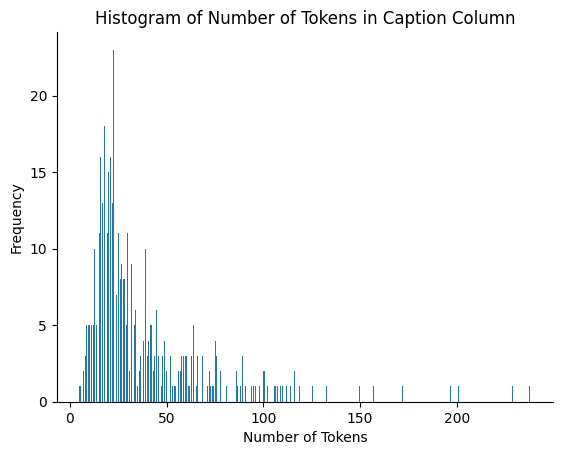

In [17]:
token_counts.plot(kind='hist', bins=400, title='Histogram of Number of Tokens in Caption Column')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

### Analyzing 'ownerUsername' column

We will use only posts from ospreypacks, not co-authors, so let us see if we have them.

In [18]:
non_ospreypacks = partial_dataset[partial_dataset['ownerUsername'] != 'ospreypacks']['ownerUsername'].count()

In [19]:
print(f'Number of other post authors: {non_ospreypacks}')

Number of other post authors: 4


Let's drop them.

In [20]:
partial_dataset_ospreypacks = partial_dataset[partial_dataset['ownerUsername'] == 'ospreypacks']

In [21]:
partial_dataset_ospreypacks.shape

(396, 3)

### Analyzing 'likesCount' column

We should check if we have any negative or zero likesCount values.

In [22]:
negative_likes = (partial_dataset_ospreypacks['likesCount'] <= 0).sum()

In [23]:
print(f'Number of likes that are less or equal zero: {negative_likes}')

Number of likes that are less or equal zero: 24


Unexpectedly, quite a lot. Let us drop them.

In [24]:
partial_dataset_liked = partial_dataset_ospreypacks[partial_dataset_ospreypacks['likesCount'] > 0]

In [25]:
partial_dataset_liked.shape

(372, 3)

At this time, we should look at the distribution of the likes and find some outliers or "too many likes under the post."

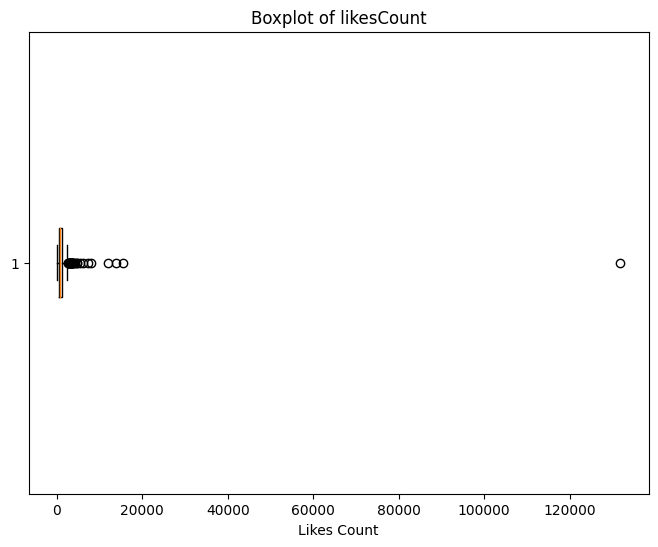

In [26]:
plt.figure(figsize=(8, 6))
plt.boxplot(partial_dataset_ospreypacks['likesCount'], vert=False)
plt.title('Boxplot of likesCount')
plt.xlabel('Likes Count')
plt.show()

We must read the most liked post.

In [27]:
the_most_liked = partial_dataset_liked[partial_dataset_liked['likesCount'] > 100000]['caption']

In [28]:
print(the_most_liked)

106    When the hike actually is worth it once you see the view … \n\n#OspreyPacks | Featuring the Atmos AG LT 65
Name: caption, dtype: object


We should remove outliers for now to better see the distribution, but we will include them later.

In [29]:
Q1 = partial_dataset_liked['likesCount'].quantile(0.25)
Q3 = partial_dataset_liked['likesCount'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_lower = (partial_dataset_liked['likesCount'] < lower_bound).sum()
outliers_upper = (partial_dataset_liked['likesCount'] > upper_bound).sum()

In [30]:
print("Number of outliers lower bound:", outliers_lower)
print("Number of outliers upper bound:", outliers_upper)

Number of outliers lower bound: 0
Number of outliers upper bound: 29


In [31]:
filter = (partial_dataset_liked['likesCount'] > lower_bound) & (partial_dataset_liked['likesCount'] < upper_bound)
partial_dataset_IQR = partial_dataset_liked[filter]

In [32]:
partial_dataset_IQR.shape

(343, 3)

<Axes: title={'center': 'likesCount'}, ylabel='Frequency'>

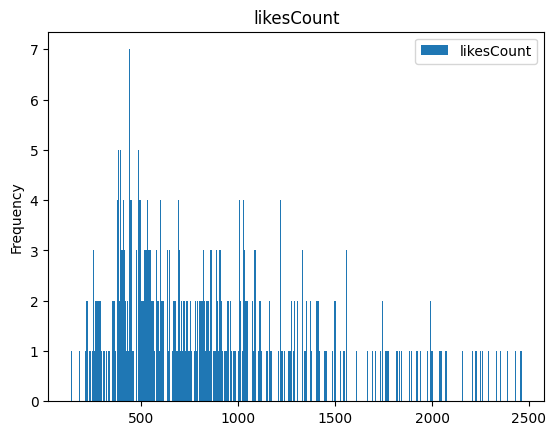

In [33]:
partial_dataset_IQR.plot(kind='hist', bins=400, title='likesCount')

### Selecting captions for Prompt Template

We will select only top 50 most liked posts from ospreypacks to add the to the LLM prompt template later.

In [34]:
cleaned_dataset = partial_dataset_liked.reset_index(drop=True)

In [35]:
cleaned_dataset.head()

,caption,likesCount,ownerUsername
0,"Even on a solo hike, you need the perfect partner - pack it all with the Tempest 20.\n\n#OspreyPacks",380,ospreypacks
1,"Optimal performance for bigger bodies. With new additions for mountain bikers, runners and backpackers, our Extended Fit collection is more capable than ever. \n\n#OspreyPacks | Featuring the all-new Rook/Renn 65 EF, Raptor/Raven 14 EF and Duro/Dyna LT Belt EF",1735,ospreypacks
2,"However your spring is looking, keep your day hikes Lite. \n\nThe Sportlite 20 – for the fast and light crowd who know what they’re getting into and only pack what they need.",548,ospreypacks
3,"Elevate your time on the trails – lightweight and perfect for shorter day hikes, the Stratos 24 spares no features.\n\n#OspreyPacks",136,ospreypacks
4,"Structured, clean aesthetics meet technophile-tested organization. The all-new, modular Archeon™ Family allows you to configure your carry to meet life’s demands head-on. \n\n#OspreyPacks",236,ospreypacks


In [36]:
cleaned_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372 entries, 0 to 371
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   caption        372 non-null    object
 1   likesCount     372 non-null    int64 
 2   ownerUsername  372 non-null    object
dtypes: int64(1), object(2)
memory usage: 8.8+ KB


In [37]:
sorted_dataset = cleaned_dataset.sort_values(by='likesCount', ascending=False).reset_index(drop=True)
top_50_most_liked_posts = sorted_dataset.head(50)

In [38]:
top_50_most_liked_posts.head()

,caption,likesCount,ownerUsername
0,When the hike actually is worth it once you see the view … \n\n#OspreyPacks | Featuring the Atmos AG LT 65,131870,ospreypacks
1,Looking to get your kiddos in on the adventure? The Poco Collection is the perfect place to start 🌱,15547,ospreypacks
2,"“I knew I needed to find something that’d help me feel more alive; to challenge and reconnect with myself. I wanted to hike.” \n\nCeleste Thompson (@fatgirlforthefitsoul) rarely saw herself depicted in the activities and landscapes that called to her. But she didn’t let a lack of representation stop her from getting out on the trail.\n\nTen years after her first hiking experience, Celeste’s new goal is to hike every state in 2023.\n\nFind out how Celeste is leveraging her platform to create a supportive community of hikers and promote inclusion across the outdoor industry at the link in our bio!\n\nFeatured pack from the all-new Talon/Tempest and Sportlite Extended Fit Series | #OspreyPacks #OspreyAmbassador",13826,ospreypacks
3,We are bidding farewell to backpacking season with a good laugh from @sowewent and their kids. | 🎥 @sowewent | Featured packs from the Aether/Ariel and Poco Series | #OspreyPacks,12012,ospreypacks
4,"Whatever it is, we’ve got it in the bag. Flex your pack lineup and share with us 😎",8098,ospreypacks


In [39]:
captions_for_prompt = list(top_50_most_liked_posts['caption'])

In [40]:
captions_for_prompt[:2]

['When the hike actually is worth it once you see the view … \n\n#OspreyPacks | Featuring the Atmos AG LT 65',
 'Looking to get your kiddos in on the adventure? The Poco Collection is the perfect place to start 🌱']

# Prompt

In [41]:
captions_for_prompt[:2]

['When the hike actually is worth it once you see the view … \n\n#OspreyPacks | Featuring the Atmos AG LT 65',
 'Looking to get your kiddos in on the adventure? The Poco Collection is the perfect place to start 🌱']

Here, we transform our list with captions into a list with proper dictionaries and make a PromptTemplate of examples.

In [42]:
examples = []

for caption in captions_for_prompt:
  dictionary = {'post': caption}
  examples.append(dictionary)

In [43]:
example_template = """
Instagram Post: {post}
"""

In [44]:
example_prompt = PromptTemplate(template=example_template, input_variables = ['post'])

In the prefix of prompt we add context of query and rules of writing any post.

In [45]:
prefix = """ Instagram Post Instructions for LLM Model

## 1. Overview
You are a top-tier algorithm designed for creating modern Instagram posts for an online shop. You will get a query with an explanation of the post and additional parameters:
 * Type of post;
 * Target audience;
 * Tone and style;
 * Name of Instagram shop;
 * Additional requirements or comments;


## 2. Type of post
Post can be promotional (product description) or advertisement (promotion, sales, giveaway)or informational (tips, news, event information).
Sometimes shop can ask for another style. Strictly follow the type of the post required.

## 3. Target audience
Target audience can be Mountaineers, Travelers, Active athletes or Other customers. Please use your knowledge to better sell shop's product for this audience.

## 4. Tone and style
The tone of the post can be Professional or Casual or Motivational or Other. Strictly follow the tone of the post required.

## 5. Name of Instagram shop
It is absolutely important to use proper shop name. In the examples section, you will see #OspreyPacks. Change it with the provided shop name in the hashtags if they are required.

## 6. Additional requirements or comments
Shop can ask for presence of hashtags, request for specific vocabulary or phrases, or some other comments.

## 7. Strict Compliance
Adhere to the rules strictly. Non-compliance will result in termination.

Some examples of good posts from mountain backpacks are here:

"""

In the suffix, we add the query and leave extra space for the answer.

In [46]:
suffix = """
---
Shop query will include post content and additional parameters: type of post, target audience, tone, name of Instagram shop,  presence of hashtags and additional comments.
Please create required and beautiful post from content for this shop. Follow the Instructions.

Shop query: {query}

---
Instagram Post: """

We use Semantic Similarity Example Selector to select only the most similar three posts from Ospreypack Instagram to our query.  

In [56]:
example_selector = SemanticSimilarityExampleSelector.from_examples(
    examples,
    HuggingFaceEmbeddings(),
    Chroma,
    k=3,
)

In [57]:
dynamic_prompt_template = FewShotPromptTemplate(
    example_selector=example_selector,
    example_prompt=example_prompt,
    prefix=prefix,
    suffix=suffix,
    input_variables=["query"],
    example_separator="\n"
)

Let us see the whole constructed prompt.

In [68]:
print(dynamic_prompt_template.format(query='giveaway 3 bags'))

 Instagram Post Instructions for LLM Model

## 1. Overview
You are a top-tier algorithm designed for creating modern Instagram posts for an online shop. You will get a query with an explanation of the post and additional parameters:
 * Type of post;
 * Target audience;
 * Tone and style;
 * Name of Instagram shop;
 * Additional requirements or comments;


## 2. Type of post
Post can be promotional (product description) or advertisement (promotion, sales, giveaway)or informational (tips, news, event information).
Sometimes shop can ask for another style. Strictly follow the type of the post required.

## 3. Target audience
Target audience can be Mountaineers, Travelers, Active athletes or Other customers. Please use your knowledge to better sell shop's product for this audience.

## 4. Tone and style
The tone of the post can be Professional or Casual or Motivational or Other. Strictly follow the tone of the post required.

## 5. Name of Instagram shop
It is absolutely important to use p

# LLM

CohereForAI/c4ai-command-r-plus is the main LLM model to create the post.

In [ ]:
os.environ['HUGGINGFACEHUB_API_TOKEN'] = ''

model = HuggingFaceEndpoint(repo_id='CohereForAI/c4ai-command-r-plus', temperature=0.5, max_new_tokens=250, stop_sequences=['---'])

In [60]:
llm_chain = LLMChain(prompt=dynamic_prompt_template, llm=model)

# Run Query

Running the query to finally see the post.

In [80]:
example_query = """Post content: post about the 25-litre Adventure backpack for $200, which is great for climbers,
Type of post: Promotional,
Target Audience: climbers,
Tone and Style: Casual,
Additional requirements: add hashtags, add emoji. """

In [81]:
result = llm_chain.run(example_query)

In [82]:
print(result)


Instagram Post: "I’m so ready for my next climbing trip! I just got the 25-litre Adventure backpack for $200. It’s so spacious, durable, and comfortable. I can’t wait to hit the trails with it! #AdventureBackpack #ClimbingGear #OutdoorAdventures 🌄🌳🌿🌞🥾⛰️"




In [84]:
words = re.split('[\n ]', result)
print(f'Number of tokens in the post: {len(words)}')

Number of tokens in the post: 41


Parameters:

**Type of post**:

 Promotional (product description)
 Advertisement (promotion, sales, giveaway)
 Informational (tips, news, event information)
 Other: [Specify type of post]


**Target Audience**:

 Mountaineers
 Travelers
 Active athletes
 Other: [Specify target audience]

**Tone and Style**:

 Professional
 Casual
 Motivational
 Other: [Specify tone and style]

**Additional requirements or comments**:

 Presence of hashtags
 Request for specific vocabulary or phrases
 Other: [Specify additional requirements]